**Face Mask detection**

Importing the necessary Python libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

Getting the data


>  For training the model, I used the dataset created by [Jessica Li](https://www.kaggle.com/jessicali9530), which contains 12 thousand images divided into Test, Train, and Validation sets.
You can dowload it from here [here](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset) .



In [3]:
# Load train and test set
train_loc = "../Face Mask Dataset/Train"
test_loc = "../Face Mask Dataset/Test"
val_loc = "../Face Mask Dataset/Validation"

Reading a sample image and performing face detection

> Reading a random sample image downloaded from the internet and perform face detection using a pre-trained face detection model.


> I used the [ Haar cascade classifier](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html), originally known as the Viola-Jones Face Detection Technique, which is one of the most popular object detection algorithms for detecting faces in images or real-time video.
You can dowload it from [here](https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml).


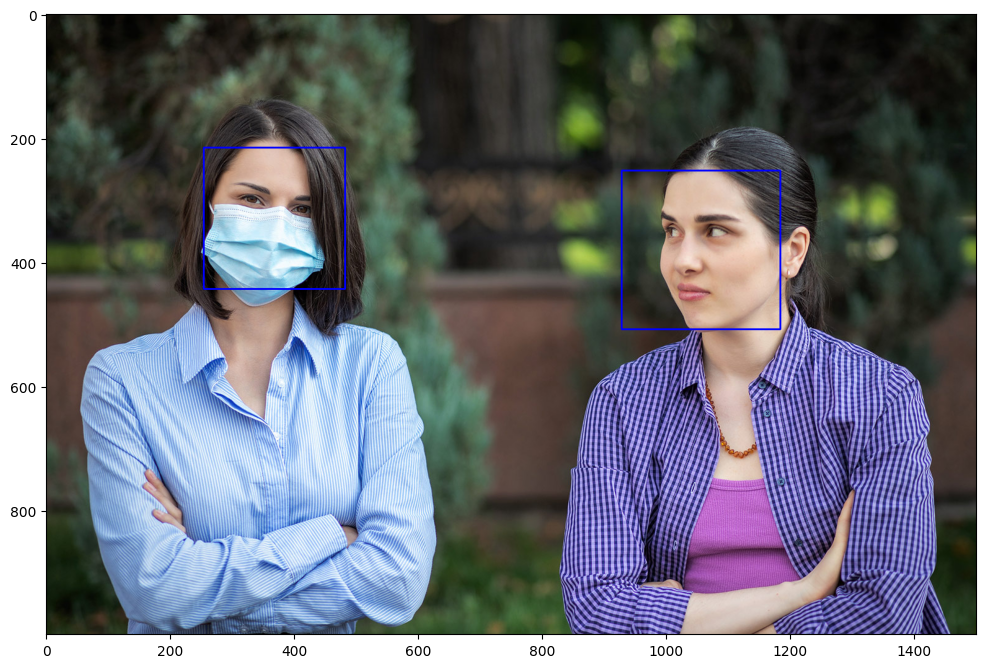

In [4]:
# Read a sample image
img = cv2.imread("../samples/sample1.jpg")
# Keep a copy of coloured image
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier("../haarcascade_frontalface_default.xml")
# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(img, scaleFactor=1.08, minNeighbors=4)
# plotting the returned values
for (x, y, w, h) in return_faces:
    cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

# display the image
plt.figure(figsize=(12, 12))
plt.imshow(orig_img)

Data preprocessing 

In [4]:
# Data augmantation
datagenerator = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)

# Train data
train_set_gen = datagenerator.flow_from_directory(directory=train_loc, target_size=(128, 128), class_mode="categorical", batch_size=32)

# Validation data
val_set_gen = datagenerator.flow_from_directory(directory=val_loc, target_size=(128, 128), class_mode="categorical", batch_size=32)

# Test data
test_set_gen = datagenerator.flow_from_directory(directory=test_loc, target_size=(128, 128), class_mode="categorical", batch_size=32)

Found 10000 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 1412 images belonging to 2 classes.


Create the mask detection transfer learning model using Keras

> I designed the model from scratch to have thirteen layer.



> Four convolutional layers, Three Max Pooling, Thre dropouts, Two Dense layers and One Flatten layer.




In [5]:
# Initialize a sequential model
model = Sequential()
model.add(Conv2D(32, (1, 1), activation='relu', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation="sigmoid"))

# Compiling the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      128       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        2112      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

Visualizing the model architecture

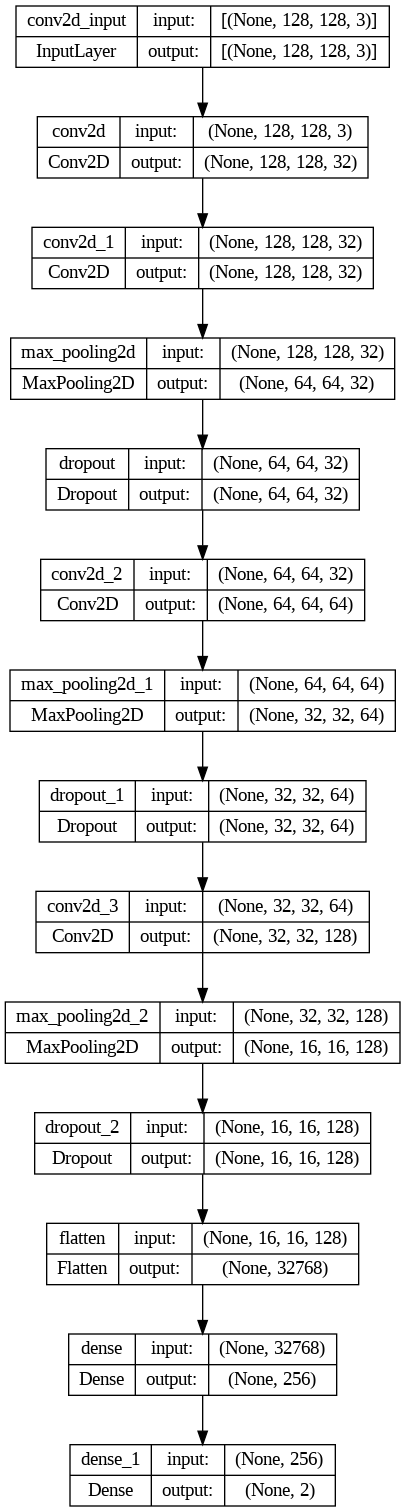

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

Train the model

In [6]:
# Fit the model on train data along with validation data
model_history = model.fit_generator(
    generator=train_set_gen,
    steps_per_epoch = len(train_set_gen) // 32,
    epochs=7,
    validation_data = val_set_gen,
    validation_steps = len(val_set_gen) // 32,
)

<ipython-input-6-bf812f0129d5>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/7
9/9 [==============================] - 148s 16s/step - loss: 1.0672 - accuracy: 0.5312 - val_loss: 0.6757 - val_accuracy: 0.5312
Epoch 2/7
9/9 [==============================] - 132s 15s/step - loss: 0.6572 - accuracy: 0.5903 - val_loss: 0.6760 - val_accuracy: 0.5625
Epoch 3/7
9/9 [==============================] - 107s 13s/step - loss: 0.5641 - accuracy: 0.7604 - val_loss: 0.5630 - val_accuracy: 0.7812
Epoch 4/7
9/9 [==============================] - 102s 12s/step - loss: 0.4110 - accuracy: 0.8785 - val_loss: 0.5676 - val_accuracy: 0.7500
Epoch 5/7
9/9 [==============================] - 105s 12s/step - loss: 0.3603 - accuracy: 0.8750 - val_loss: 0.3634 - val_accuracy: 0.9688
Epoch 6/7
9/9 [==============================] - 104s 12s/step - loss: 0.2545 - accuracy: 0.9062 - val_loss: 0.5146 - val_accuracy: 0.6875
Epoch 7/7
9/9 [==============================] - 103s 11s/step - loss: 0.3056 - accuracy: 0.8889 - val_loss: 0.4542 - val_accuracy: 0.8125


Evaluate the model performance on test set

In [7]:
model_loss, model_acc = model.evaluate(test_set_gen)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

45/45 [==============================] - 10s 227ms/step - loss: 0.4320 - accuracy: 0.8102
Model has a loss of 0.43 and accuracy 81.02%


Saving the model

In [10]:
model.save('../trained_model.h5')

Test the model on the sample image

1/1 [==============================] - 0s 210ms/step


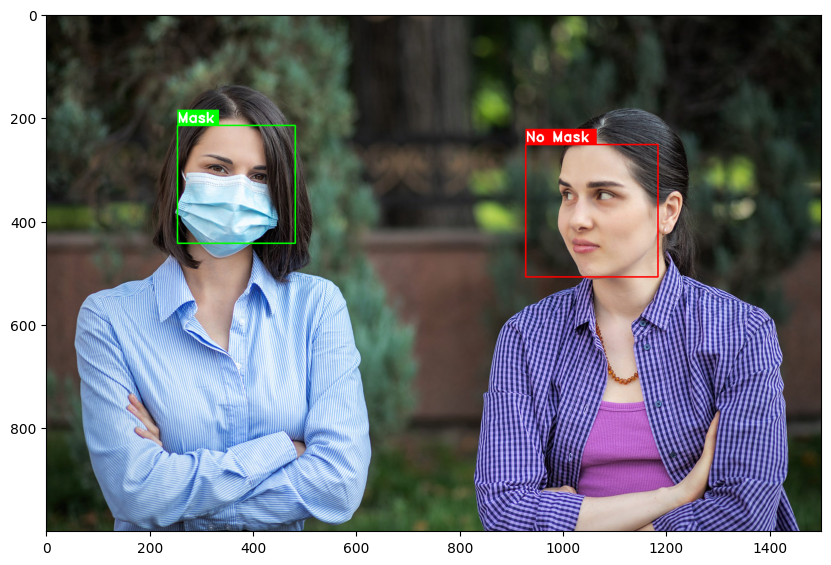

In [ ]:
# label for mask detection
mask_det_label = {0: "Mask", 1: "No Mask"}
mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
pad_y = 1  # padding for result text

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# For detected faces in the image
for i in range(len(return_faces)):
    (x, y, w, h) = return_faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (224, 224))
    cropped_face = np.reshape(cropped_face, [1, 224, 224, 3]) / 255.0
    # make model prediction
    mask_result = model.predict(cropped_face) 
    # get mask/no mask based on prediction
    print_label = mask_det_label[mask_result.argmax()] 
    label_colour = mask_det_label_colour[mask_result.argmax()]

    # Print result
    (t_w, t_h), _ = cv2.getTextSize(print_label, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)
  
    # draw rectangle
    cv2.rectangle(
        main_img, (x, y + pad_y), (x + t_w, y - t_h - pad_y - 6), label_colour, -1,
        )   
    # print text 
    cv2.putText(
        main_img, print_label, (x, y - 6), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2,
        )     
    # draw bounding box on face
    cv2.rectangle(
        main_img, (x, y), (x + w, y + h), label_colour, 1,
        )    
    # draw bounding box on face
    cv2.rectangle(
        main_img, (x, y), (x + w, y + h), label_colour, thickness=2,
        )    
# display image
plt.figure(figsize=(10, 10))
plt.imshow(main_img) 

**Then, you can run this code after training the model and saving it, to detect the face mask from a live video stream from the laptop's webcam**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

face_detection_model = cv2.CascadeClassifier("../haarcascade_frontalface_default.xml")
model = load_model('../trained_model.h5')
mask_det_label = {0: "Mask", 1: "No Mask"}
mask_det_label_colour = {0: (0, 255, 0), 1: (0, 0, 255)}
pad_y = 1

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()   
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    
    return_faces = face_detection_model.detectMultiScale(img, scaleFactor=1.08, minNeighbors=4)

    for i in range(len(return_faces)):
        (x, y, w, h) = return_faces[i]
        cropped_face = frame[y : y + h, x : x + w]
        cropped_face = cv2.resize(cropped_face, (128, 128))
        cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
        mask_result = model.predict(cropped_face)
        print_label = mask_det_label[mask_result.argmax()]
        label_colour = mask_det_label_colour[mask_result.argmax()]
        (t_w, t_h), _ = cv2.getTextSize(
            print_label, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)
        cv2.rectangle(
            frame, (x, y + pad_y), (x + t_w, y - t_h - pad_y - 6), label_colour, -1,
        )
        cv2.putText(
            frame, print_label, (x, y - 6), cv2.FONT_HERSHEY_DUPLEX, 0.9, (255, 255, 255), 2,
        )
        cv2.rectangle(
            frame, (x, y), (x + w, y + h), label_colour, 1,
        )
        cv2.rectangle(
            frame, (x, y), (x + w, y + h), label_colour, thickness=2,
        )    
    cv2.imshow("webcam", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()